# Cartographier le manteau neigeux avec Python 

En quelques lignes de code, nous vous proposons de cartographier le manteau neigeux. Nous utiliserons pour cela les données du réseau nivo-météorologique français, ainsi que les bibliothèques Pandas (et son extension géospatiale Geopandas) et Folium. 

Ce notebook complète l'article publié sur le blog de Makina Corpus. 

## Dépendances 

Si vous n'utilisez pas les environnements pré-configurés mis à votre disposition dans le répertoire GitHub, vous aurez besoin de vérifier l'installation de certaines bibliothèques Python. 

Voici la liste des dépendances de ce notebook :

```
folium
geopandas
matplotlib
pandas
jupyter
rtree
descartes
```

Vous aurez donc besoin d'installer la bibliothèque [libspatialindex](http://libspatialindex.github.io/), et les paquets python folium, geopandas, matplotlib, pandas, jupyter, rtree, descartes (voir le readme).


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

## Préparation des données géographiques

Dans ce notebook, nous utilisons les **données du réseau nivo-météorologique français**. Les données sont disponibles dans le dossier `data/`. Vous pouvez aussi télécharger le fichier des stations ([ici](https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Nivo/postesNivo.json)), ainsi qu'un fichier de mesures archivées (onglet "Téléchargement de données archivées" de [cette page](https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=94&id_rubrique=32)) sur le site de Météo France.

### Carte du réseau de stations

Nous pouvons rapidement visualiser les positions des stations sur une **carte dynamique** à l'aide de la bibliothèque Folium. Cette bibliothèque permet de créer facilement des cartes qui sont générées par la bibliothèque javascript Leaflet.

In [2]:
# Create a map centered at the given latitude and longitude
stations_map = folium.Map(location=[45,1], zoom_start=5)

# Add data from a geojson file
stations_map.add_child(folium.GeoJson('postesNivo.json'))

# Display the map
display(stations_map)

### Enregistrement des stations dans un geodataframe

Pour travailler avec ces données, nous les chargons dans un objet GeoDataFrame à l'aide de la méthode `read_file` de la bibliothèque Geopandas.

In [3]:
# Read the geojson file
stations = gpd.read_file("postesNivo.json")
# Convert the IDs to int
stations.ID = stations.ID.astype(int)
# Get info about data
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 6 columns):
Latitude     143 non-null object
Longitude    143 non-null object
ID           143 non-null int64
Altitude     143 non-null object
Nom          143 non-null object
geometry     143 non-null object
dtypes: int64(1), object(5)
memory usage: 6.8+ KB


In [4]:
# Display the first rows (5 by default)
stations.head()

,Latitude,Longitude,ID,Altitude,Nom,geometry
0,46.766000,6.359167,7392,1036,METABIEF_STATION,POINT (6.359167 46.766)
1,46.020833,6.970833,7393,2196,LE TOUR BALME,POINT (6.970833 46.020833)
2,46.341167,6.708167,7454,1535,Bernex,POINT (6.708167 46.341167)
3,45.247667,6.732667,7456,2166,Aussois,POINT (6.732667 45.247667)
4,46.315333,6.673333,7457,790,VACHERESSE AUXI,POINT (6.673333 46.315333)


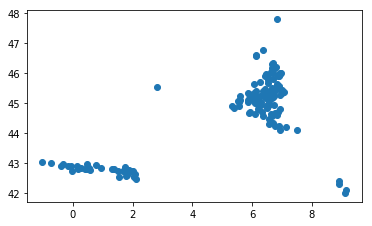

In [5]:
# Plot the geometries
stations.plot()

Le système de coordonnées est accessible via l'attribut `crs` de notre geoDataFrame, ici nos positions sont en **WGS84** (EPSG:4326). Il s'agit du système géodésique le plus fréquent lorsque l'on travaille avec des coordonnées géographiques, typiquement des positions GPS.

In [6]:
# Get the coordinate reference system used to define the geometries
stations.crs

{'init': 'epsg:4326'}

En plus des méthodes standard de la bibliothèque Pandas, GeoPandas fournit une **indexation basée sur les coordonnées** avec l'indexeur `cx`. Il retourne les géométries intersectant la zone de sélection. La sélection d'un extrait du dataframe n'est plus réalisée par numéro ou nom de lignes et/ou colonnes, mais directement par les coordonnées de la zone d'intérêt.

Nous utilisons cet indexeur pour extraire les stations situées dans les Alpes.

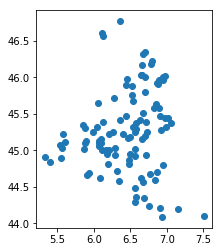

In [7]:
# Extract the stations located in the Alpes 
alpes = stations.cx[4:8,44:47]
alpes.plot()

### Import des emprises de communes

Les stations sont représentées par des points. Pour cartographier le manteau neigeux à l'échelle de la commune, nous récupérons les emprises des communes des Alpes grâce au projet [France GeoJSON](https://france-geojson.gregoiredavid.fr/). Nous créons à partir de ces fichiers un dataframe contenant l'emprise des communes avec lesquelles nous travaillons.

In [8]:
# Read geoJSON files
com73 = gpd.read_file('communes-73-savoie.geojson')
com74 = gpd.read_file('communes-74-haute-savoie.geojson')
com38 = gpd.read_file('communes-38-isere.geojson')
com05 = gpd.read_file('communes-05-hautes-alpes.geojson')
# Concatenate the geodataframes
communes = pd.concat([com73, com74, com38, com05])
# Display the first lines 
communes.head()

,code,nom,geometry
0,73197,Peisey-Nancroix,"POLYGON ((6.86187 45.45389, 6.85537 45.454, 6...."
1,73023,Aussois,"POLYGON ((6.71509 45.23432, 6.71246 45.23752, ..."
2,73117,Fourneaux,"POLYGON ((6.64543 45.19696, 6.65057 45.19479, ..."
3,73157,Modane,"POLYGON ((6.60137 45.16331, 6.60417 45.1623, 6..."
4,73322,Villarodin-Bourget,"POLYGON ((6.71459 45.16239, 6.71152 45.16404, ..."


### Jointure spatiale

Geopandas permet de réaliser des jointures spatiales avec sa méthode `sjoin`. Avec l'opérateur `within`, nous associons les stations aux communes en intersectant leurs géométries.

In [9]:
# Spatial join between the station's positions and the city's surfaces
map_df = gpd.sjoin(alpes, communes, how='right', op='within')
# Display the first rows of the dataframe 
map_df.head()

,index_left,Latitude,Longitude,ID,Altitude,Nom,code,nom,geometry
index_right,,,,,,,,,
1,3.0,45.247667,6.732667,7456.0,2166,Aussois,73023,Aussois,"POLYGON ((6.71509 45.23432, 6.71246 45.23752, ..."
3,65.0,45.155833,6.664833,7890.0,2208,Val Frejus,73157,Modane,"POLYGON ((6.60137 45.16331, 6.60417 45.1623, 6..."
4,46.0,45.188500,6.698833,7863.0,1960,La Norma,73322,Villarodin-Bourget,"POLYGON ((6.71459 45.16239, 6.71152 45.16404, ..."
7,16.0,45.274167,6.922333,7567.0,2101,Val Cenis (La Berche),73290,Val-Cenis,"POLYGON ((7.05118 45.22533, 7.04721 45.22581, ..."
8,67.0,45.371667,6.583333,7892.0,1700,Meribel Mottaret,73015,Allues,"POLYGON ((6.54646 45.45317, 6.54908 45.45306, ..."


## Préparation des données statistiques

Les hauteurs de neige mesurées par les différentes stations du réseau sont archivées dans des fichiers csv.

Nous enregistrons le contenu du fichier contenant les données du mois de décembre 2018 dans un dataframe Pandas en utilisant la méthode `read_csv`.

In [10]:
# Read the csv file containing the measurements
snow2018 = pd.read_csv('nivo.201812.csv', delimiter=';', parse_dates=['date'])
# Remove rows without a snow height measurement
snow2018 = snow2018[snow2018.ht_neige != 'mq']
# Convert the snow heights to float
snow2018.ht_neige=snow2018.ht_neige.astype('float')
# Get info about data
snow2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1580 entries, 0 to 1598
Data columns (total 50 columns):
numer_sta        1580 non-null int64
date             1580 non-null datetime64[ns]
haut_sta         1580 non-null float64
dd               1580 non-null object
ff               1580 non-null object
t                1580 non-null object
td               1580 non-null object
u                1580 non-null object
ww               1580 non-null object
w1               1580 non-null object
w2               1580 non-null object
n                1580 non-null object
nbas             1580 non-null object
hbas             1580 non-null object
cl               1580 non-null object
cm               1580 non-null object
ch               1580 non-null object
rr24             1580 non-null object
tn12             1580 non-null object
tn24             1580 non-null object
tx12             1580 non-null object
tx24             1580 non-null object
ht_neige         1580 non-null float64
ssfrai    

In [11]:
# Index the data with the dates of mesurement
snow = snow2018[['numer_sta','date','haut_sta','ht_neige']].set_index('date')

In [12]:
# Calculate the mean snow height by station
data_for_map = snow.groupby('numer_sta').resample('M').mean()

## Association des données

In [13]:
# Set the station IDs as index in the dataframes
map_df.set_index('ID', inplace=True)
data_for_map.set_index('numer_sta', inplace=True)

In [14]:
# Merge the two dataframes
merged = map_df.join(data_for_map)
# Remove NaN values
merged.dropna(inplace=True)

Comme certaines communes possèdent plusieurs stations de mesure, nous calculons une hauteur moyenne de neige pour chacune d'entre elles. Pour cela, nous réindexons notre dataframe avec le code de chaque commune (colonne qui nous sert à regrouper les mesures), puis nous calculons la hauteur moyenne de neige par commune. Cette information est enregistrée dans une nouvelle colonne.

In [15]:
# Reset the dataframe index
merged.reset_index(level=0, inplace=True)
# Use the city code as index
merged.set_index('code',inplace=True)
# Calculate the mean snow height for each city
merged['com_ht_neige']=merged.groupby(['code']).mean().ht_neige

## Affichage sur une carte

Comme vu précédemment, une **carte statique** est facilement accessible avec la méthode `plot` de Geopandas.

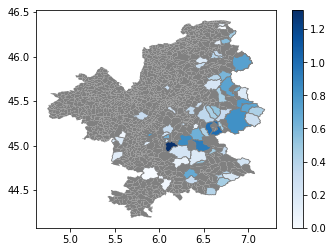

In [16]:
fig, ax = plt.subplots()

communes.plot(color='gray', ax=ax)
merged.plot(column='ht_neige', cmap='Blues', linewidth=0.8, edgecolor='1.5',ax=ax, legend=True)

Pour obtenir une **carte dynamique**, on peut à nouveau utiliser la bibliothèque Folium et sa méthode `chloropleth`. Cette méthode prend en paramètres un fichier geoJSON qui contient les géométries à afficher et un dataframe Pandas qui contient les valeurs statistiques associées. On enregistre donc les géométries des communes dans un fichier geoJSON avec la méthode `to_file`.

In [17]:
# Save a geodataframe in a geoJSON file 
merged[['index', 'nom','geometry']].to_file('nivo2O18.json', driver='GeoJSON')

/home/makina/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Désormais nous avons tout pour cartographier le manteau neigeux des communes des Alpes sur un fond de cartes Open Street Map.

In [19]:
# Create a map
snow_map = folium.Map(location=[45,1], zoom_start=5)

# Add the chloropleth
snow_map.choropleth(
      geo_data='nivo2O18.json', # geoJSON file
      name='choropleth',
      data=merged, # Pandas dataframe
      columns=['index','ht_neige'], # key and value of interest from the dataframe
      key_on='feature.properties.index', # key to link the json file and the dataframe
      fill_color='Blues', # colormap
      fill_opacity=0.9,
      line_opacity=0.2,
      legend_name='Hauteur moyenne de neige (m)'
)

# Add the stations
for ix, row in merged.iterrows(): 
    # Create a popup tab with the station name and its mean snow height
    popup_df = pd.DataFrame(data=[['Station', str(row['Nom'])], ['Altitude','{:4d} m'.format(int(row['haut_sta']))], ['Neige', '{:01.2f} m'.format(row['ht_neige'])]])
    popup_html = popup_df.to_html(classes='table table-striped table-hover table-condensed table-responsive', index=False, header=False)
    # Create a marker on the map
    folium.CircleMarker(location = [float(row['Latitude']),float(row['Longitude'])], radius=2, popup=folium.Popup(popup_html), color='#0000FF', fill_color='#0000FF').add_to(snow_map)

# Display the map
display(snow_map)